## Ré-échantillonage

In [21]:
import conf_mgt
from utils import yamlread
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme()

In [22]:
intermediate_steps = False #return intermediate results (usefull to create gifs, but will use lot of memory - around 3GB for one 256x256 image)
conf = conf_mgt.conf_base.Default_Conf()
conf.update(yamlread('confs/my_conf-2.yml'))
print(conf.inpa_inj_sched_prev) #Are you about to use RePainting ?print(conf.diffusion_steps) #may not be the good one
conf.intermediate_steps = intermediate_steps
print(conf.intermediate_steps)


True
False


## On s'intéresse ici à la stratégie de ré-échantillonage (qui remplace le 'slowing-down' couramment utilisé) qui est détaillé dans l'article. Ses hyper paramètres sont dans le fichier de configuration.

In [23]:
conf.schedule_jump_params = {'t_T': 250, 'n_sample': 1, 'jump_length': 10, 'jump_n_sample': 10}

### Ici on indique qu'on a t_T étapes de diffusion à inverser. Dès lors que l'on inverse jump_length étapes supplémentaires on ré-échantillonne jump_n_sample fois (ici ré-échantilloner signifie ajouter du bruit jump_length fois et inverser à nouveau le meme nombre de fois). 

### On peut calculer le nombre total d'étapes nécessaires pour réaliser l'entièreté du processus. On a besoin de t_T étapes auxquelles on ajoute celles supplémentaires au nombre de (jump_n_sample-1)*(2*jump_length) à chaque ré-échantillonage. Le nombre total peut-être trompeur car environ la moitié de ces étapes sont très rapides (diffusion) là où les étapes d'inversion sont plus coûteuses (passage dans le modèle).

In [24]:
tmp = conf.schedule_jump_params
tmp['t_T'] + (-1 + tmp['t_T']/tmp['jump_length'])*(tmp['jump_n_sample']-1)*(2*(tmp['jump_length']))

4570.0

### Pour visualiser le processus de diffusion appliqué avec rééchantillonage, on peut regarder la ligne 535 de gaussian_diffusion.py. Le code est celui de la fonction p_sample_loop_progressive qui a pour tâche de gérer le processus de diffusion inverse en calculant la séquence de temps souhaités et en appliquant les bonnes opérations (diffusion et diffusion inverse alternées selon la stratégie de ré-échantillonage). Pour calculer l'échelle des temps elle utilise la fonction get_schedule_jump qui récupère les hyperparamètres que nous avons donnés en configuration.

In [25]:
from guided_diffusion.scheduler import get_schedule_jump
from matplotlib import pyplot as plt
import numpy as np


if conf.schedule_jump_params:
            times = get_schedule_jump(**conf.schedule_jump_params)

            time_pairs = list(zip(times[:-1], times[1:]))


### Ci-dessous une visualisation graphique du processus de ré-échantillonage

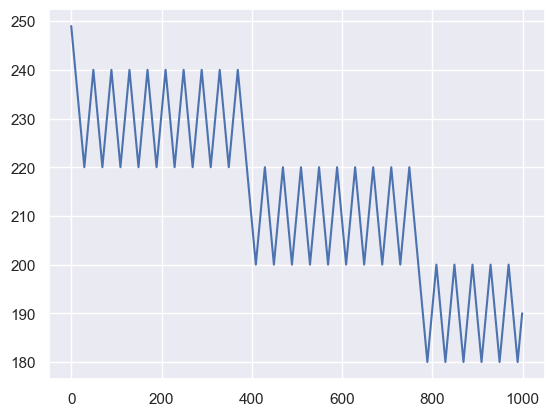

In [13]:
plt.plot(np.array(time_pairs)[:1000,0])
plt.savefig('timepairs.png',dpi=500)


### Le temps complet du processus est bien celui calculé plus haut.

In [53]:
len(np.array(time_pairs)[:])

4570

### Pour les phases de diffusion, on pourrait les réaliser en une seule opération. Toutefois le code des auteurs ne le fait pas. Le gain computationnel est toutefois négligeable puisque ce sont les opérations de diffusion inverse (par le modèle) qui ont le coût impactant le temps de calcul. Cette méthode permet également de partir de n'importe quel endroit dans le processus de diffusion plus facilement en tronquant la variable time_pairs.

In [26]:
from guided_diffusion.scheduler import get_schedule_jump
from matplotlib import pyplot as plt
import numpy as np


if conf.schedule_jump_params:
            times = get_schedule_jump(**conf.schedule_jump_params)

            time_pairs = list(zip(times[:-1], times[1:]))
            time_pairs = np.array(time_pairs)
            allowed = np.array([0 if i[0]<i[1] else 1 for i in time_pairs])
allowed[110]

1

In [51]:
allowed[(190*np.array(range(23))+200)]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

In [33]:
to_save = (190*np.array(range(23))+200)
time_pairs[to_save][:,0]

array([229, 219, 209, 199, 189, 179, 169, 159, 149, 139, 129, 119, 109,
        99,  89,  79,  69,  59,  49,  39,  29,  19,   9])

In [34]:
to_save

array([ 200,  390,  580,  770,  960, 1150, 1340, 1530, 1720, 1910, 2100,
       2290, 2480, 2670, 2860, 3050, 3240, 3430, 3620, 3810, 4000, 4190,
       4380])